In [ ]:
#pip install yfinance

In [1]:
import pandas as pd
from statsmodels.tsa.api import VAR
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import yfinance as yf
import matplotlib.pyplot as plt

In [3]:
stk_data = yf.download("RELIANCE.NS", start="2013-06-01", end="2022-02-11")
stk_data

C:\Users\admin\AppData\Local\Temp\ipykernel_1512\4010520275.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stk_data = yf.download("RELIANCE.NS", start="2013-06-01", end="2022-02-11")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,,
2013-06-03,167.620453,171.332817,167.056671,170.981786,14165128
2013-06-04,165.982346,170.152124,165.758971,168.194884,14752690
2013-06-05,170.620163,171.109473,166.046170,166.046170,12748842
2013-06-06,168.492722,171.024366,167.663032,170.194677,17113393
2013-06-07,166.705643,170.620121,166.152512,168.960714,9420701
...,...,...,...,...,...
2022-02-04,1065.005981,1072.840675,1060.346346,1069.437239,11061241
2022-02-07,1058.519165,1076.655277,1052.991451,1069.894201,10714467


In [4]:
stk_data=stk_data[["Open","High","Low","Close"]]

In [7]:
#performing Minmax scaler
from sklearn.preprocessing import MinMaxScaler
Ms = MinMaxScaler()
data1= Ms.fit_transform(stk_data)
print("Len:",data1.shape)

Len: (2144, 4)


In [8]:
# Convert back to DataFrame for indexing
scaled_column = pd.DataFrame(stk_data, index=stk_data.index, columns=stk_data.columns)

In [11]:
scaled_column

Price,Open,High,Low,Close
Ticker,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS,RELIANCE.NS
Date,,,,
2013-06-03,170.981786,171.332817,167.056671,167.620453
2013-06-04,168.194884,170.152124,165.758971,165.982346
2013-06-05,166.046170,171.109473,166.046170,170.620163
2013-06-06,170.194677,171.024366,167.663032,168.492722
2013-06-07,168.960714,170.620121,166.152512,166.705643
...,...,...,...,...
2022-02-04,1069.437239,1072.840675,1060.346346,1065.005981
2022-02-07,1069.894201,1076.655277,1052.991451,1058.519165


In [24]:
#Split train and test set
training_size = round(len(scaled_column ) * 0.80)
print(training_size)
X_train=scaled_column[:training_size]
X_test=scaled_column[training_size:]
print("X_train length:",X_train.shape)
print("X_test length:",X_test.shape)
y_train=scaled_column[:training_size]
y_test=scaled_column[training_size:]
print("y_train length:",y_train.shape)
print("y_test length:",y_test.shape)

1715
X_train length: (1715, 4)
X_test length: (429, 4)
y_train length: (1715, 4)
y_test length: (429, 4)


In [26]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
# Define combinations manually
combinations = [['Close', 'High'],['Close', 'High', 'Open'],['Close', 'High', 'Open', 'Low']]

# Empty list to store results
performance = {"Model": [],"RMSE": [],"MaPe": [],"Lag": [],"Test": []}


In [30]:

test_obs = 100

# Loop through combinations
for cols in combinations:
    #dataset = data1[cols]
    train = scaled_column[:-test_obs]
    test = scaled_column[-test_obs:]
    
    model = VAR(train)
    for i in [1,2,3,4,5]:
        
        results = model.fit(i)
        print('Order =', i)
        print('AIC: ', results.aic)
        print('BIC: ', results.bic)
        print()

   # model = VAR(train)

    # Select best lag order using AIC
    lag_selection = model.select_order(maxlags=12)
    order = lag_selection.selected_orders['aic']

    # Fit and forecast
    result = model.fit(order)
  
    lagged_values = train.values[-order:]
    pred = result.forecast(y=lagged_values, steps=test_obs)
    #pred_df = pd.DataFrame(pred, columns=cols, index=test.index)  # Assign correct date index here
    #preds=pd.DataFrame(pred,columns=stk_data)
    pred_df = pd.DataFrame(pred, columns=train.columns, index=test.index)

    pred_df.to_csv("varforecasted_{}.csv".format(test_obs))

    # Calculate metrics
    rmse = round(mean_squared_error(test, pred_df, squared=False), 4)
    mape = round(mean_absolute_percentage_error(test, pred_df), 6)

    # Append to performance
    performance["Model"].append(cols)
    performance["RMSE"].append(rmse)
    performance["MaPe"].append(mape)
    performance["Lag"].append(order)
    performance["Test"].append(test_obs)


# Print performance metrics
perf_df = pd.DataFrame(performance)
print(perf_df)



Order = 1
AIC:  12.054921227966688
BIC:  12.109959647886585

Order = 2
AIC:  11.982626597502755
BIC:  12.08173563763698

Order = 3
AIC:  11.943727703924997
BIC:  12.086942867308688

Order = 4
AIC:  11.935962176716595
BIC:  12.123319012944538

Order = 5
AIC:  11.909759804968136
BIC:  12.141293910278707

Order = 1
AIC:  12.054921227966688
BIC:  12.109959647886585

Order = 2
AIC:  11.982626597502755
BIC:  12.08173563763698

Order = 3
AIC:  11.943727703924997
BIC:  12.086942867308688

Order = 4
AIC:  11.935962176716595
BIC:  12.123319012944538

Order = 5
AIC:  11.909759804968136
BIC:  12.141293910278707

Order = 1
AIC:  12.054921227966688
BIC:  12.109959647886585

Order = 2
AIC:  11.982626597502755
BIC:  12.08173563763698

Order = 3
AIC:  11.943727703924997
BIC:  12.086942867308688

Order = 4
AIC:  11.935962176716595
BIC:  12.123319012944538

Order = 5
AIC:  11.909759804968136
BIC:  12.141293910278707

                      Model     RMSE      MaPe  Lag  Test
0             [Close, High]  6

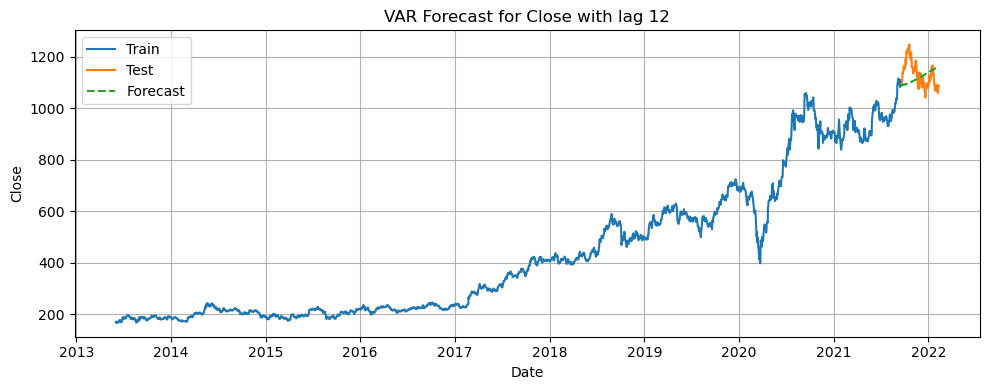

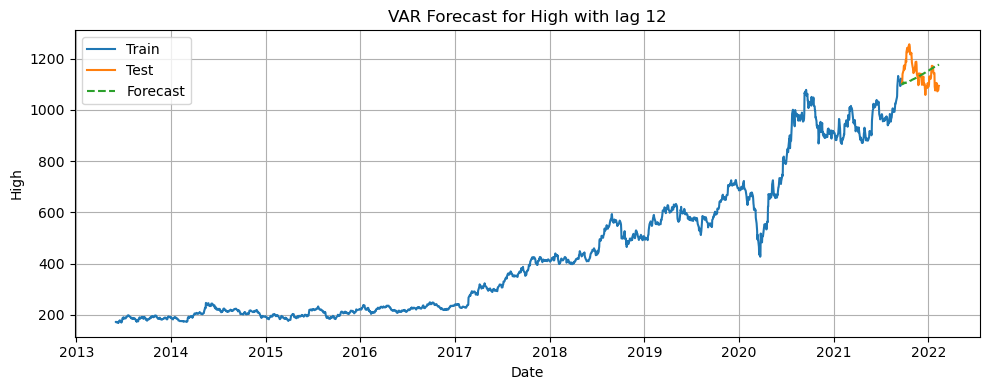

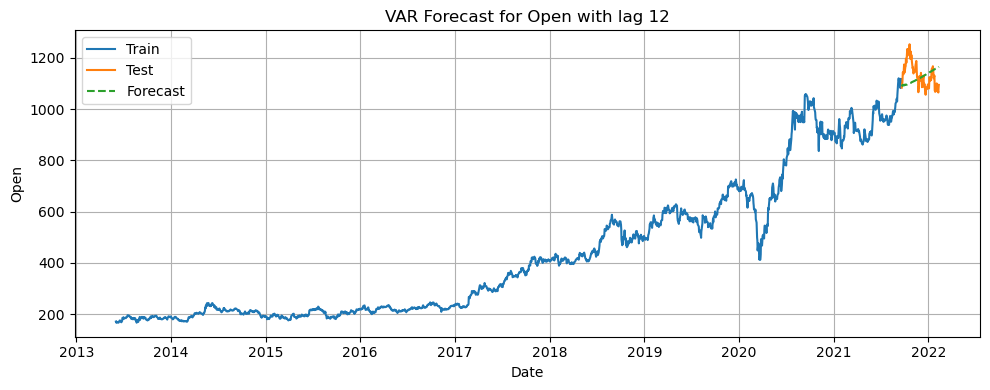

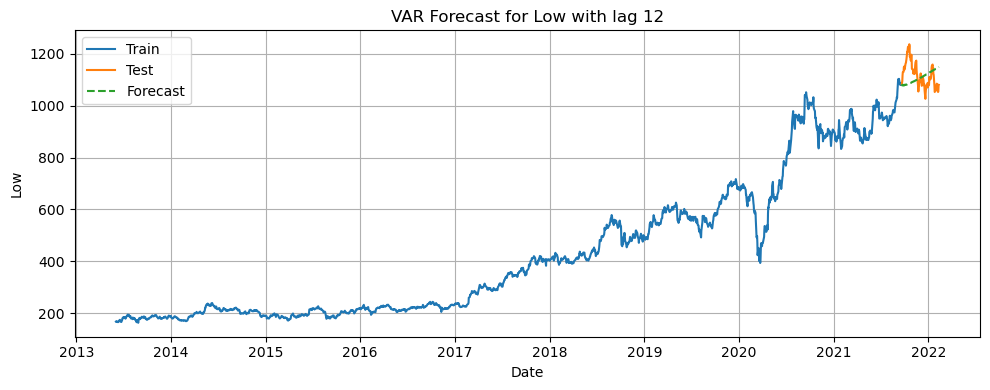

In [31]:
  # ---- Plotting ----
for col in cols:
    plt.figure(figsize=(10, 4))
    plt.plot(train.index, train[col], label='Train')
    plt.plot(test.index, test[col], label='Test')
    plt.plot(pred_df.index, pred_df[col], label='Forecast', linestyle='--')
    plt.title(f"VAR Forecast for {col} with lag {order}")
    plt.xlabel("Date")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
